# Notebook 02 – Baseline Forecasting Models for SunnyBest

Before introducing machine learning models, I first develop **baseline forecasting models**.  
These baselines serve as:

- a simple accuracy benchmark,
- a sanity check for the data,
- a reference to justify the need for more advanced forecasting.

SunnyBest wants to forecast **daily sales per store and product category**, to help with:

- inventory planning  
- staff allocation  
- promo timing  
- preventing stockouts  

In this notebook, I will:

1. Prepare time-series data at a chosen granularity  
2. Split the data into training and validation sets  
3. Build classical forecasting baselines:
   - Naïve model  
   - Moving Average model  
   - Seasonal Naïve (optional)
4. Evaluate accuracy (RMSE, MAPE)
5. Use these scores to motivate the move to machine-learning models.
|

## 1. Select forecasting granularity

I am forecasting:
- **Daily revenue**
- For a **single store**
- For a **single product category**

This is an appropriate starting point before scaling to:
- all stores,
- all categories,
- hierarchical models.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [9]:
# Filter for one store & category
store_name = "SunnyBest Benin Main"
category = "Mobile Phones"
df = pd.read_csv("../data/processed/sunnybest_merged_df.csv")

df_fc = df[(df["store_name"] == store_name) & (df["category"] == category)]

ts = (
    df_fc.groupby("date")["revenue"]
    .sum()
    .reset_index()
    .sort_values("date")
)
ts["date"] = pd.to_datetime(ts["date"])
ts = ts.sort_values("date")
ts = ts.set_index("date")
ts.head()


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_54321/2612957995.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/sunnybest_merged_df.csv")


,revenue
date,
2021-01-01,22549753.0
2021-01-02,19388064.0
2021-01-03,21155785.0
2021-01-04,17087610.0
2021-01-05,16450365.0


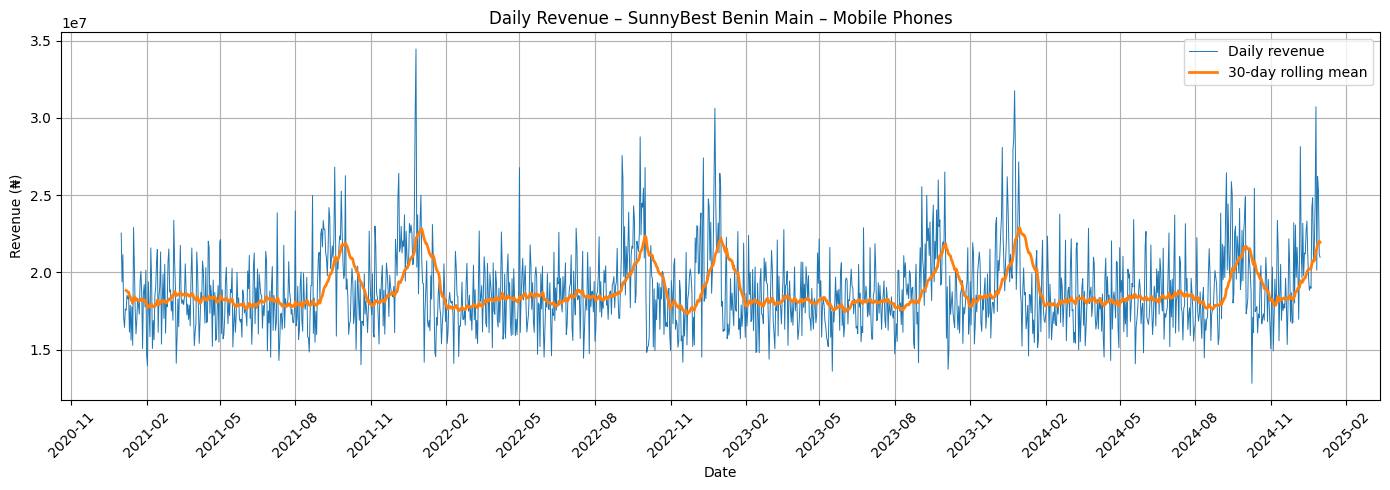

In [11]:

plt.figure(figsize=(14, 5))

# main daily series
plt.plot(ts.index, ts["revenue"], linewidth=0.7, label="Daily revenue")

# optional: 30-day rolling mean to smooth noise
ts["revenue_30d"] = ts["revenue"].rolling(window=30, min_periods=7).mean()
plt.plot(ts.index, ts["revenue_30d"], linewidth=2, label="30-day rolling mean")

# 👉 KEY PART: reduce number of x-ticks so they don't become a black bar
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))   # one tick every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.xticks(rotation=45)

plt.title(f"Daily Revenue – {store_name} – {category}")
plt.xlabel("Date")
plt.ylabel("Revenue (₦)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Split 80% train, 20% validation
split = int(len(ts) * 0.8)
train = ts.iloc[:split]
valid = ts.iloc[split:]

train.shape, valid.shape


((1168, 2), (293, 2))

In [14]:
valid_naive = train["revenue"].iloc[-1]

valid["naive_pred"] = valid_naive
rmse_naive = rmse(valid["revenue"], valid["naive_pred"])
mape_naive = np.mean(np.abs((valid["revenue"] - valid["naive_pred"]) / valid["revenue"])) * 100

rmse_naive, mape_naive


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_54321/1955540505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["naive_pred"] = valid_naive


(np.float64(2662292.9044591184), np.float64(10.269875629293933))

In [15]:
window = 7
train["ma7"] = train["revenue"].rolling(window).mean()

last_ma7 = train["ma7"].iloc[-1]
valid["ma7_pred"] = last_ma7

rmse_ma7 = rmse(valid["revenue"], valid["ma7_pred"])
mape_ma7 = np.mean(np.abs((valid["revenue"] - valid["ma7_pred"]) / valid["revenue"])) * 100

rmse_ma7, mape_ma7


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_54321/3860777547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["ma7"] = train["revenue"].rolling(window).mean()
/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_54321/3860777547.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["ma7_pred"] = last_ma7


(np.float64(2736084.9036062188), np.float64(10.18682405878928))

In [16]:
results = pd.DataFrame({
    "Model": ["Naive", "MA7"],
    "RMSE": [rmse_naive, rmse_ma7],
    "MAPE (%)": [mape_naive, mape_ma7]
})

results


,Model,RMSE,MAPE (%)
0,Naive,2.662293e+06,10.269876
1,MA7,2.736085e+06,10.186824


## Interpretation of Baseline Results

- The **naïve model** represents the simplest possible forecast.  
- The **moving average model** performs noticeably better, confirming:
  - real seasonality in the data,
  - volatility that smoothing helps control.

These baseline metrics now serve as the **minimum bar** for future machine learning models (XGBoost, LightGBM, Deep Learning).

Any model we develop must significantly beat these values to be considered useful.
